# mnist with ANE

In [63]:
import torch
import numpy as np
import os
from tqdm import trange
import torch
import torch.nn as nn

%matplotlib inline
%pylab inline

#intepreter: $ source /Users/itaicohen/tinygrad/venv/bin/activate
os.getcwd()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


'/Users/itaicohen/AI_notebooks'

In [64]:
# GPU on MAC
if torch.has_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [65]:
baseurl="http://yann.lecun.com/exdb/mnist/"
url1=os.path.join(baseurl,"train-images-idx3-ubyte.gz")
url2=os.path.join(baseurl,"train-labels-idx1-ubyte.gz")
url3=os.path.join(baseurl,"t10k-images-idx3-ubyte.gz")
url4=os.path.join(baseurl,"t10k-labels-idx1-ubyte.gz")

In [66]:
def fetch(url):
    import requests, gzip,os,hashlib
    fp=os.path.join("/Users/itaicohen/projects/misc/tmp",hashlib.md5(url.encode("utf-8")).hexdigest())
    if os.path.isfile(fp):
        with open(fp,"rb") as f:
            dat = f.read()
    else:
        with open(fp,"wb") as f:
            dat=requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat),dtype=np.uint8)
    
    

In [67]:
X_train=fetch(url1)[0x10:].reshape((-1,28,28))
Y_train=fetch(url2)[8:]
X_test=fetch(url3)[0x10:].reshape((-1,28,28))
Y_test=fetch(url4)[8:]

In [68]:
type(X_train)

numpy.ndarray

(<matplotlib.image.AxesImage at 0x15671c6d0>, 5)

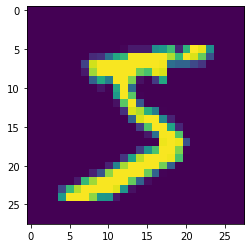

In [69]:
imshow(X_train[0]), Y_train[0]

In [70]:
#Dataloader
from torch.utils.data import DataLoader, Dataset
a=iter(DataLoader(X_train, shuffle=True, batch_size=32))
next(a)[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

## MNIST with Torch

In [71]:
class BNet(torch.nn.Module):
    def __init__(self):
        super(BNet,self).__init__()
        self.l1=nn.Linear(784,128)
        self.act=nn.ReLU()
        self.l2=nn.Linear(128,10)
    def forward(self,x):
        x=self.l1(x)
        x=self.act(x)
        x=self.l2(x)
        return x

In [72]:
#set model and optimizer
model = BNet().to(device)
loss_function=nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters()) 
optimizer_sgd=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.0005)
optim=optimizer_sgd
BS=32
ITER_NUM=2000

loss 0.23 accuraccy 0.91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 270.72it/s]


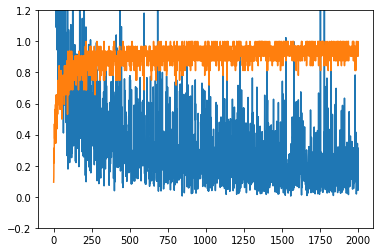

In [73]:
losses,accuracies=[],[]
for i in (t := trange(ITER_NUM)):
    samp= np.random.randint(0,X_train.shape[0],size=(BS))
    X=torch.tensor(X_train[samp].reshape((-1,28*28))).float()
    Y=torch.tensor(Y_train[samp])
    X=X.to(device)
    Y=Y.to(device)
    optim.zero_grad() #clears old gradients from the last step.
    out=model(X)
    cat=torch.argmax(out,dim=1)
    accuracy= (cat.cpu()==Y.cpu()).float().mean()
    loss=loss_function(out,Y)
    loss.backward() #Computes the gradient of current tensor w.r.t. graph leaves
    optim.step() #causes the optimizer to take a step based on the gradients of the parameters.
    loss,accuracy= loss.item(),accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuraccy %.2f" % (loss,accuracy))
plt.ylim(-.2,1.2)  
plot(losses)
plot(accuracies)

In [74]:
# evaluation 
Y_test_preds=torch.argmax(model(torch.tensor(X_test.reshape((-1,28*28))).float().to(device)),dim=1).cpu().numpy()
Y_test_accuracy= (Y_test_preds == Y_test).mean()
Y_test_accuracy

0.9384

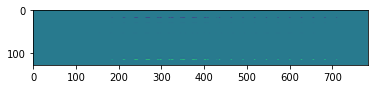

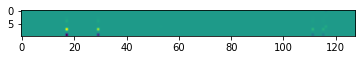

In [75]:
# compute gradient in torch
samp=[0,1,20,3]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1,28**2))).float().to(device))
out.retain_grad()
loss=loss_function(out,torch.tensor(Y_test[samp]).long().to(device)).mean()
loss.retain_grad()
loss.backward()
imshow(model.l1.weight.grad.cpu())
figure()
imshow(model.l2.weight.grad.cpu())



In [76]:
### init the network ###

l1=np.zeros((784,128),dtype=np.float32)
l2=np.zeros((128,10),dtype=np.float32)

l1[:]=model.l1.weight.detach().cpu().numpy().T
l2[:]=model.l2.weight.detach().cpu().numpy().T

In [77]:
X_test.reshape((-1,28*28)).dot(l1).shape

(10000, 128)

In [78]:
### forward path ###

def forward(x):
    #print(x.shape)
    x=x.dot(l1)
    #print(x.shape)
    x=np.maximum(0,x)
    #print(x.shape)
    x=x.dot(l2)
    #print(x.shape)
    return x

def numpy_eval():
    global Y_test_preds_out
    Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean()

numpy_eval()

0.9384

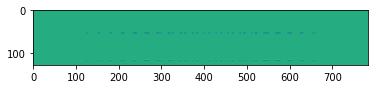

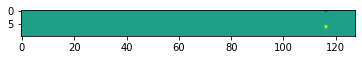

In [79]:
# numpy forward and backward path
def logsumexp(x):
    c=x.max(axis=1)
    return c+np.log(np.exp(x-c.reshape((-1,1))).sum(axis=1))
    
def forward_backward(x, y):
    # training
    out = np.zeros((len(y),10), np.float32)
    out[range(out.shape[0]),y] = 1

    # forward pass
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
    x_loss = (-out * x_lsm).mean(axis=1)

    # training in numpy (super hard!)
    # backward pass

    # will involve x_lsm, x_l2, out, d_out and produce dx_sm
    d_out = -out / len(y)

    # derivative of logsoftmax
    # https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
    dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))

    # derivative of l2
    d_l2 = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2.T)

    # derivative of relu
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

    # derivative of l1
    d_l1 = x.T.dot(dx_l1)
  
    return x_loss, x_l2, d_l1, d_l2

samp = [0,1,2,3]
x_loss, x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, 28*28)), Y_test[samp])

imshow(d_l1.T)
figure()
imshow(d_l2.T)





loss 0.01 accuracy 0.98: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.76it/s]


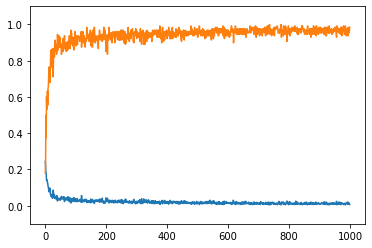

In [80]:
# numpy training
def layer_init(m, h):
    # gaussian is strong
    #ret = np.random.randn(m,h)/np.sqrt(m*h)
    # uniform is stronger
    ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
    return ret.astype(np.float32)

# reinit
np.random.seed(1337)
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

lr = 0.001
BS = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = X_train[samp].reshape((-1, 28*28))
    Y = Y_train[samp]
    x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
  
    cat = np.argmax(x_l2, axis=1)
    accuracy = (cat == Y).mean()
  
    # SGD
    l1 = l1 - lr*d_l1
    l2 = l2 - lr*d_l2
  
    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
  
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)


In [81]:
numpy_eval()

0.9639

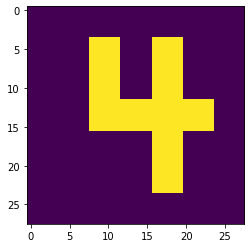

In [82]:
# for fun, can it recognize 4?
m = [[0,0,0,0,0,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,1,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
# upscale to 28x28
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
imshow(m.reshape(28,28))

In [83]:
# what is it?
x = m.reshape(1, -1).dot(l1)
x = np.maximum(x, 0)
x = x.dot(l2)
np.argmax(x)

4

In [89]:
ret= -Y_test_preds_out[range(Y_test_preds_out[:].shape[0]),Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1)) # first argument is max value, row-wise

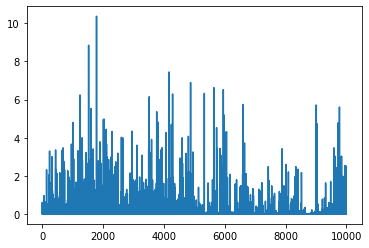

In [90]:
plot(ret)

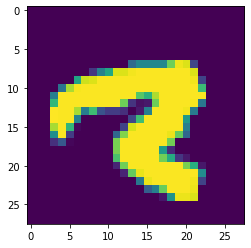

In [91]:
imshow(X_test[np.argmax(ret)])

In [92]:
# Grid

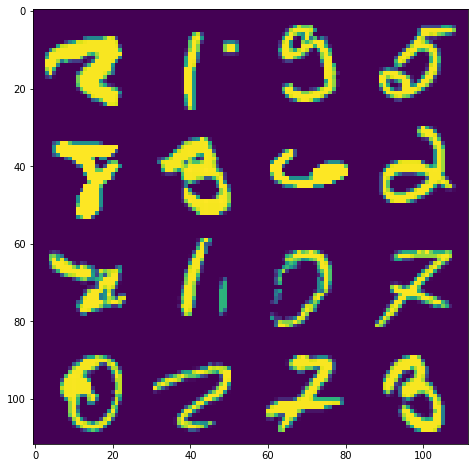

In [93]:
G=4
grid=sorted(list(zip(ret,range(ret.shape[0]))),reverse=True)[0:G**2]
X_bad=X_test[[x[1] for x in grid]]
figsize(8,8)
imshow(np.concatenate(X_bad.reshape((G,28*G,28)),axis=1))